<a href="https://colab.research.google.com/github/shivam-kotwalia/data-science-project/blob/master/Multi_label_and_multi_class_classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic Commnets Clasification

## Multi Label and Multi Class classification problem

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy 
import tqdm
import joblib

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 47.1MB/s]
 38% 9.00M/23.4M [00:00<00:00, 41.3MB/s]
100% 23.4M/23.4M [00:00<00:00, 77.8MB/s]
 34% 9.00M/26.3M [00:00<00:00, 35.3MB/s]
100% 26.3M/26.3M [00:00<00:00, 75.8MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 98.3MB/s]


In [7]:
! unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
df = pd.read_csv("train.csv")

In [9]:
df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [15]:
 df.shape

(159571, 8)

In [16]:
df.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Data is quite large for Colab to handle, we need to shorten the data

In [17]:
# Shuffel data
df = df.sample(frac=1).reset_index(drop=True)
df = df.iloc[:10_000]
df.shape

(10000, 8)

In [0]:
X = df[["comment_text"]]
Y = df.iloc[:, 2:]

In [19]:
for i in Y.columns:
  print(i, " -- ", Y[i].sum())

toxic  --  924
severe_toxic  --  93
obscene  --  509
threat  --  24
insult  --  454
identity_hate  --  69


In [20]:
X.comment_text.isna().sum()   # No emppty cell

0

In [21]:
X.loc[X.comment_text.str.isnumeric()] # No only numerical values

,comment_text


In [22]:
lengths_of_sentences = np.array(X.comment_text.apply(lambda x:len(str(x))))
lengths_of_sentences.min()

8

In [23]:
X.loc[lengths_of_sentences < 15]

,comment_text
9477,you suck


## Text Preprocessing

In [24]:
X.comment_text = X.comment_text.str.replace("\n", " ")
X.comment_text = X.comment_text.str.replace("\r", " ")
X.comment_text = X.comment_text.str.replace("[^\w\s]", " ")
X.comment_text = X.comment_text.str.lstrip()
X.comment_text = X.comment_text.str.rstrip()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [0]:
nlp = spacy.load("en")
def text_preprocessing(i, texts):
  final_texts = []
  for doc in nlp.pipe(texts):
    final_texts.append((" ".join([chunck.lemma_ for chunck in doc if not chunck.is_stop])).replace("-PRON-", ""))
  return final_texts

In [0]:
partitions = spacy.util.minibatch(X.comment_text, 10_00)
executor = joblib.Parallel(n_jobs=2, backend="multiprocessing", prefer="processes")
do = joblib.delayed(text_preprocessing)
tasks = (do(i, batch) for i, batch in enumerate(partitions))
processed_text = executor(tasks)

In [27]:
len(processed_text), len(processed_text[0])

(10, 1000)

In [28]:
processed_text_1 = []
for part in tqdm.tqdm_notebook(processed_text):
  for row in part:
    processed_text_1.append(row)

In [29]:
len(processed_text_1)

10000

In [0]:
processed_text_df = pd.DataFrame(processed_text_1, columns=["text"])

In [31]:
processed_text_df.shape

(10000, 1)

In [32]:
print(df.comment_text.head())

print("\n\n")

print(processed_text_df.head())

0    How about you let us all know once you have ga...
1    "\nAnd I have concerns about yours. I acknowle...
2    "\nThere's also the new section entitled ""Cus...
3    "\n\n COPYVIO \n\nAlmost everything I have che...
4    I would also support 195's view. You clearly t...
Name: comment_text, dtype: object



                                                text
0                     how let know gaze crystal ball
1  and  concern    acknowledge difficulty face   ...
2  there s new section entitle    customer experi...
3  copyvio    almost  check copy web page   pleas...
4   support 195 s view    clearly think clever di...


In [33]:
import tensorflow_hub as hub
import tensorflow as tf


W0602 13:39:19.142156 140113689683840 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
### NEED TO DELETE SOME VARIABLES TO FREE RAM
del df
del processed_text
del processed_text_1
del X

In [35]:
! free -m 

              total        used        free      shared  buff/cache   available
Mem:          13022         928        9852           0        2241       12037
Swap:             0           0           0


Had to reduce the size the text again, as we were getting Error - 


```
ResourceExhaustedError
```



In [36]:
g = tf.Graph()
with g.as_default():
  text_input = tf.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")
  embedded_text = embed(text_input)
  init_ops = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()


W0602 13:39:35.817218 140113689683840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [37]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

             processed_text_df:   3.1MiB
                             Y: 468.9KiB
          lengths_of_sentences:  78.2KiB
                           _11:  13.9KiB
                           _16:  13.9KiB
                          part:   8.9KiB
                            _9:   1.7KiB
                           _oh:   648.0B
                           Out:   648.0B
                          _i37:   578.0B


In [0]:
def embbed_func(texts):
  with tf.Session(graph=g) as sess:
    sess.run(init_ops)
    result = sess.run(embedded_text, feed_dict={text_input: texts})
  return result

In [0]:
partitions = spacy.util.minibatch(processed_text_df.text.tolist(), 1000)
embeddings = [embbed_func(i) for i in partitions]

In [46]:
len(embeddings), embeddings[0].shape

(10, (1000, 512))

In [0]:
final_embeddings = np.concatenate(embeddings)

In [50]:
final_embeddings.shape

(10000, 512)

In [0]:
del embeddings

### Multi Label Classification

In [52]:
Y.shape

(10000, 6)

In [0]:
from keras.models import Sequential
from keras.layers import Dense

In [0]:
model = Sequential()
model.add(Dense(256, activation="relu"))
model.add(Dense(6, activation="sigmoid"))

In [0]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metric=["acc"])

In [0]:
model_history = model.fit(final_embeddings, Y.values, epochs=50, verbose=0)

Text(0.5, 1.0, 'Loss Graph')

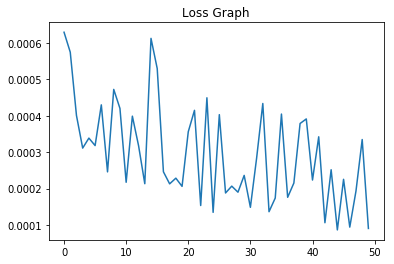

In [74]:
plt.plot(model_history.history["loss"])
plt.title("Loss Graph")

In [76]:
model.predict(final_embeddings[10:15])

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0861626e-07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.1920929e-07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.2932946e-22, 3.8686565e-26]], dtype=float32)

In [77]:
Y[10:15]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
10,0,0,0,0,0,0
11,0,0,0,0,0,0
12,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0
